In [3]:
# Data Processing Imports
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Logger Imports
import time
import logging
import sys
from logging.handlers import TimedRotatingFileHandler

# Model Specific Imports
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

# Visulaization and metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score
import dataframe_image as dfi
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [4]:

FORMATTER = logging.Formatter("%(asctime)s —  %(levelname)s — %(message)s")
LOG_FILE = "LR.log"

def get_console_handler():
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(FORMATTER)
    return console_handler

def get_file_handler():
    file_handler = TimedRotatingFileHandler(LOG_FILE, when='midnight')
    file_handler.setFormatter(FORMATTER)
    return file_handler

def get_logger(logger_name):
    logger = logging.getLogger(logger_name)
    
    if (logger.hasHandlers()): # important as removes duplicate loggers (and thus duplicate log entries)
        logger.handlers.clear()
    logger.setLevel(logging.DEBUG) # better to have too much log than not enough
    logger.addHandler(get_console_handler())
    logger.addHandler(get_file_handler())
    # with this pattern, it's rarely necessary to propagate the error up to parent
    logger.propagate = False
    return logger

logger = get_logger("LR")

In [5]:
Categories_Durum=['CFP-CK1','CFP-CK2'] # [Infected, Healthy]
Categories_Bread=['CFP-CK3','CFP-CK4'] # [Infected, Healthy]
Categories_Test=['CFP-B179','CFP-B223'] # 39/103 or 37.8% infected; 21/105 or 20% infected

All_Categories = [Categories_Durum, Categories_Bread,Categories_Test]

datadir='/student/sch923/Thesis/data/test_wheat_2021/Wheat/TestSamples' 
#path which contains all the categories of images

In [6]:
flat_arr, target_arr=[],[]

# creating species specific data sets
for Categories in All_Categories:
    flat_arr.append(list())
    target_arr.append(list())
    for i in Categories:
        logger.info(f'loading category: {i}')    
        path=os.path.join(datadir,i) 
        image_count = 0
        for img in os.listdir(path):  
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(150,150,3))  
            flat_arr[len(flat_arr)-1].append(img_resized.flatten())

            if i in Categories_Test:
                target_arr[len(flat_arr)-1].append(0) # As only % infection is known, all are assumed to be infected
            else:
                target_arr[len(flat_arr)-1].append(Categories.index(i))
            image_count += 1
        logger.info(f'loaded category: {i} successfully, found {image_count} images')

2021-07-01 13:03:54,707 —  INFO — loading category: CFP-CK1
2021-07-01 13:04:01,174 —  INFO — loaded category: CFP-CK1 successfully, found 43 images
2021-07-01 13:04:01,176 —  INFO — loading category: CFP-CK2
2021-07-01 13:04:08,348 —  INFO — loaded category: CFP-CK2 successfully, found 48 images
2021-07-01 13:04:08,351 —  INFO — loading category: CFP-CK3
2021-07-01 13:04:11,983 —  INFO — loaded category: CFP-CK3 successfully, found 24 images
2021-07-01 13:04:11,986 —  INFO — loading category: CFP-CK4
2021-07-01 13:04:16,652 —  INFO — loaded category: CFP-CK4 successfully, found 31 images
2021-07-01 13:04:16,654 —  INFO — loading category: CFP-B179
2021-07-01 13:04:32,067 —  INFO — loaded category: CFP-B179 successfully, found 103 images
2021-07-01 13:04:32,069 —  INFO — loading category: CFP-B223
2021-07-01 13:04:46,361 —  INFO — loaded category: CFP-B223 successfully, found 96 images


In [7]:
list_arr_fun = lambda l : np.array(l)
flat_data=list(map(list_arr_fun, flat_arr))
target=list(map(list_arr_fun, target_arr))

df_Durum=pd.DataFrame(flat_data[0])
df_Bread=pd.DataFrame(flat_data[1])
df_Complete=pd.DataFrame(np.append(flat_data[0], flat_data[1], axis=0))
df_Test=pd.DataFrame(flat_data[2])

df_Durum['Target']=target[0]
df_Bread['Target']=target[1]
df_Complete['Target']=np.append(target[0], target[1], axis=0)
df_Test['Target']=target[2]

x_Durum=df_Durum.iloc[:,:-1] #input data 
y_Durum=df_Durum.iloc[:,-1] #output data

x_Bread=df_Bread.iloc[:,:-1] #input data 
y_Bread=df_Bread.iloc[:,-1] #output data

x_Complete=df_Complete.iloc[:,:-1] #input data 
y_Complete=df_Complete.iloc[:,-1] #output data

x_Test=df_Complete.iloc[:,:-1] #input data 
y_Test=df_Complete.iloc[:,-1] #output data


In [8]:
# Data Splitting
logger.info('======= Start Of Data Split =======')
x_train_Durum,x_test_Durum,y_train_Durum,y_test_Durum=train_test_split(x_Durum,y_Durum,test_size=0.20,random_state=77,stratify=y_Durum)
logger.info('Durum Splitted Successfully')
x_train_Bread,x_test_Bread,y_train_Bread,y_test_Bread=train_test_split(x_Bread,y_Bread,test_size=0.20,random_state=77,stratify=y_Bread)
logger.info('Bread Splitted Successfully')
x_train_Complete,x_test_Complete,y_train_Complete,y_test_Complete=train_test_split(x_Complete,y_Complete,test_size=0.20,random_state=77,stratify=y_Complete)
logger.info('Complete Splitted Successfully')
x_test_Test,_,y_test_Test,_=train_test_split(x_Test,y_Test,test_size=0.20,random_state=77,stratify=y_Test)
logger.info('Test Splitted Successfully')
logger.info('======= End Of Data Split =======\n')

2021-07-01 13:04:46,925 —  INFO — ======= Start Of Data Split =======
2021-07-01 13:04:46,946 —  INFO — Durum Splitted Successfully
2021-07-01 13:04:46,964 —  INFO — Bread Splitted Successfully
2021-07-01 13:04:46,995 —  INFO — Complete Splitted Successfully
2021-07-01 13:04:47,024 —  INFO — Test Splitted Successfully
2021-07-01 13:04:47,025 —  INFO — ======= End Of Data Split =======



In [9]:
def modelTrainer(model, x_train, y_train, model_name, method_name):
    logger.info(f"Starting to train {method_name} model...")
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    logger.info(f"The {model_name} model trained in: {str(end - start)} seconds")

In [10]:
# Logistic Regression Models

logger.info('======= Start Of Logistic Regression Model Generation =======')
LogR_param_grid={'penalty':['l2'], 'C':[0.1,1,10,100], 'max_iter':[1024], 'solver': ['lbfgs'] } 
LogR_model_Durum=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Bread=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_Complete=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)

modelTrainer(LogR_model_Durum, x_train_Durum, y_train_Durum, "Durum", "LogR")
modelTrainer(LogR_model_Bread, x_train_Bread, y_train_Bread, "Bread", "LogR")
modelTrainer(LogR_model_Complete, x_train_Complete, y_train_Complete, "Complete", "LogR")


2021-07-01 13:04:47,993 —  INFO — ======= Start Of Logistic Regression Model Generation =======
2021-07-01 13:04:47,995 —  INFO — Starting to train LogR model...
2021-07-01 13:05:14,659 —  INFO — The Durum model trained in: 26.66272759437561 seconds
2021-07-01 13:05:14,672 —  INFO — Starting to train LogR model...
2021-07-01 13:05:34,822 —  INFO — The Bread model trained in: 20.147037506103516 seconds
2021-07-01 13:05:34,834 —  INFO — Starting to train LogR model...
2021-07-01 13:06:16,293 —  INFO — The Complete model trained in: 41.457865715026855 seconds


In [11]:
# SVM Models

logger.info('======= Start Of SVM Model Generation =======')
SVM_param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
SVM_model_Durum=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Bread=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Complete=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)

modelTrainer(SVM_model_Durum, x_train_Durum, y_train_Durum, "Durum", "SVM")
modelTrainer(SVM_model_Bread, x_train_Bread, y_train_Bread, "Bread", "SVM")
modelTrainer(SVM_model_Complete, x_train_Complete, y_train_Complete, "Complete", "SVM")



2021-07-01 13:06:16,541 —  INFO — ======= Start Of SVM Model Generation =======
2021-07-01 13:06:16,542 —  INFO — Starting to train SVM model...
2021-07-01 13:06:33,623 —  INFO — The Durum model trained in: 17.080390453338623 seconds
2021-07-01 13:06:33,628 —  INFO — Starting to train SVM model...
2021-07-01 13:06:42,459 —  INFO — The Bread model trained in: 8.829839944839478 seconds
2021-07-01 13:06:42,462 —  INFO — Starting to train SVM model...
2021-07-01 13:07:16,929 —  INFO — The Complete model trained in: 34.465415477752686 seconds


In [12]:
# K Nearest Neighbors Models

logger.info('======= Start Of K Nearest Neighbors Model Generation =======')
KNN_param_grid={'n_neighbors':[5], 'weights':['uniform', 'distance']}
KNN_model_Durum=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Bread=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Complete=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)

modelTrainer(KNN_model_Durum, x_train_Durum, y_train_Durum, "Durum", "KNN")
modelTrainer(KNN_model_Bread, x_train_Bread, y_train_Bread, "Bread", "KNN")
modelTrainer(KNN_model_Complete, x_train_Complete, y_train_Complete, "Complete", "KNN")


2021-07-01 13:07:17,317 —  INFO — ======= Start Of K Nearest Neighbors Model Generation =======
2021-07-01 13:07:17,318 —  INFO — Starting to train KNN model...
2021-07-01 13:07:18,582 —  INFO — The Durum model trained in: 1.2627737522125244 seconds
2021-07-01 13:07:18,583 —  INFO — Starting to train KNN model...
2021-07-01 13:07:19,713 —  INFO — The Bread model trained in: 1.1283318996429443 seconds
2021-07-01 13:07:19,714 —  INFO — Starting to train KNN model...
2021-07-01 13:07:20,938 —  INFO — The Complete model trained in: 1.222402572631836 seconds


In [13]:
# Random Forest Models

logger.info('======= Start Of Random Forest Model Generation =======')
RanF_param_grid={'n_estimators':[100], 'criterion': ['gini', 'entropy']}
RanF_model_Durum=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Bread=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Complete=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)

modelTrainer(RanF_model_Durum, x_train_Durum, y_train_Durum, "Durum", "RanF")
modelTrainer(RanF_model_Bread, x_train_Bread, y_train_Bread, "Bread", "RanF")
modelTrainer(RanF_model_Complete, x_train_Complete, y_train_Complete, "Complete", "RanF")

2021-07-01 13:07:21,203 —  INFO — ======= Start Of Random Forest Model Generation =======
2021-07-01 13:07:21,204 —  INFO — Starting to train RanF model...
2021-07-01 13:07:22,954 —  INFO — The Durum model trained in: 1.7487084865570068 seconds
2021-07-01 13:07:22,955 —  INFO — Starting to train RanF model...
2021-07-01 13:07:24,546 —  INFO — The Bread model trained in: 1.5903220176696777 seconds
2021-07-01 13:07:24,549 —  INFO — Starting to train RanF model...
2021-07-01 13:07:26,658 —  INFO — The Complete model trained in: 2.10787296295166 seconds


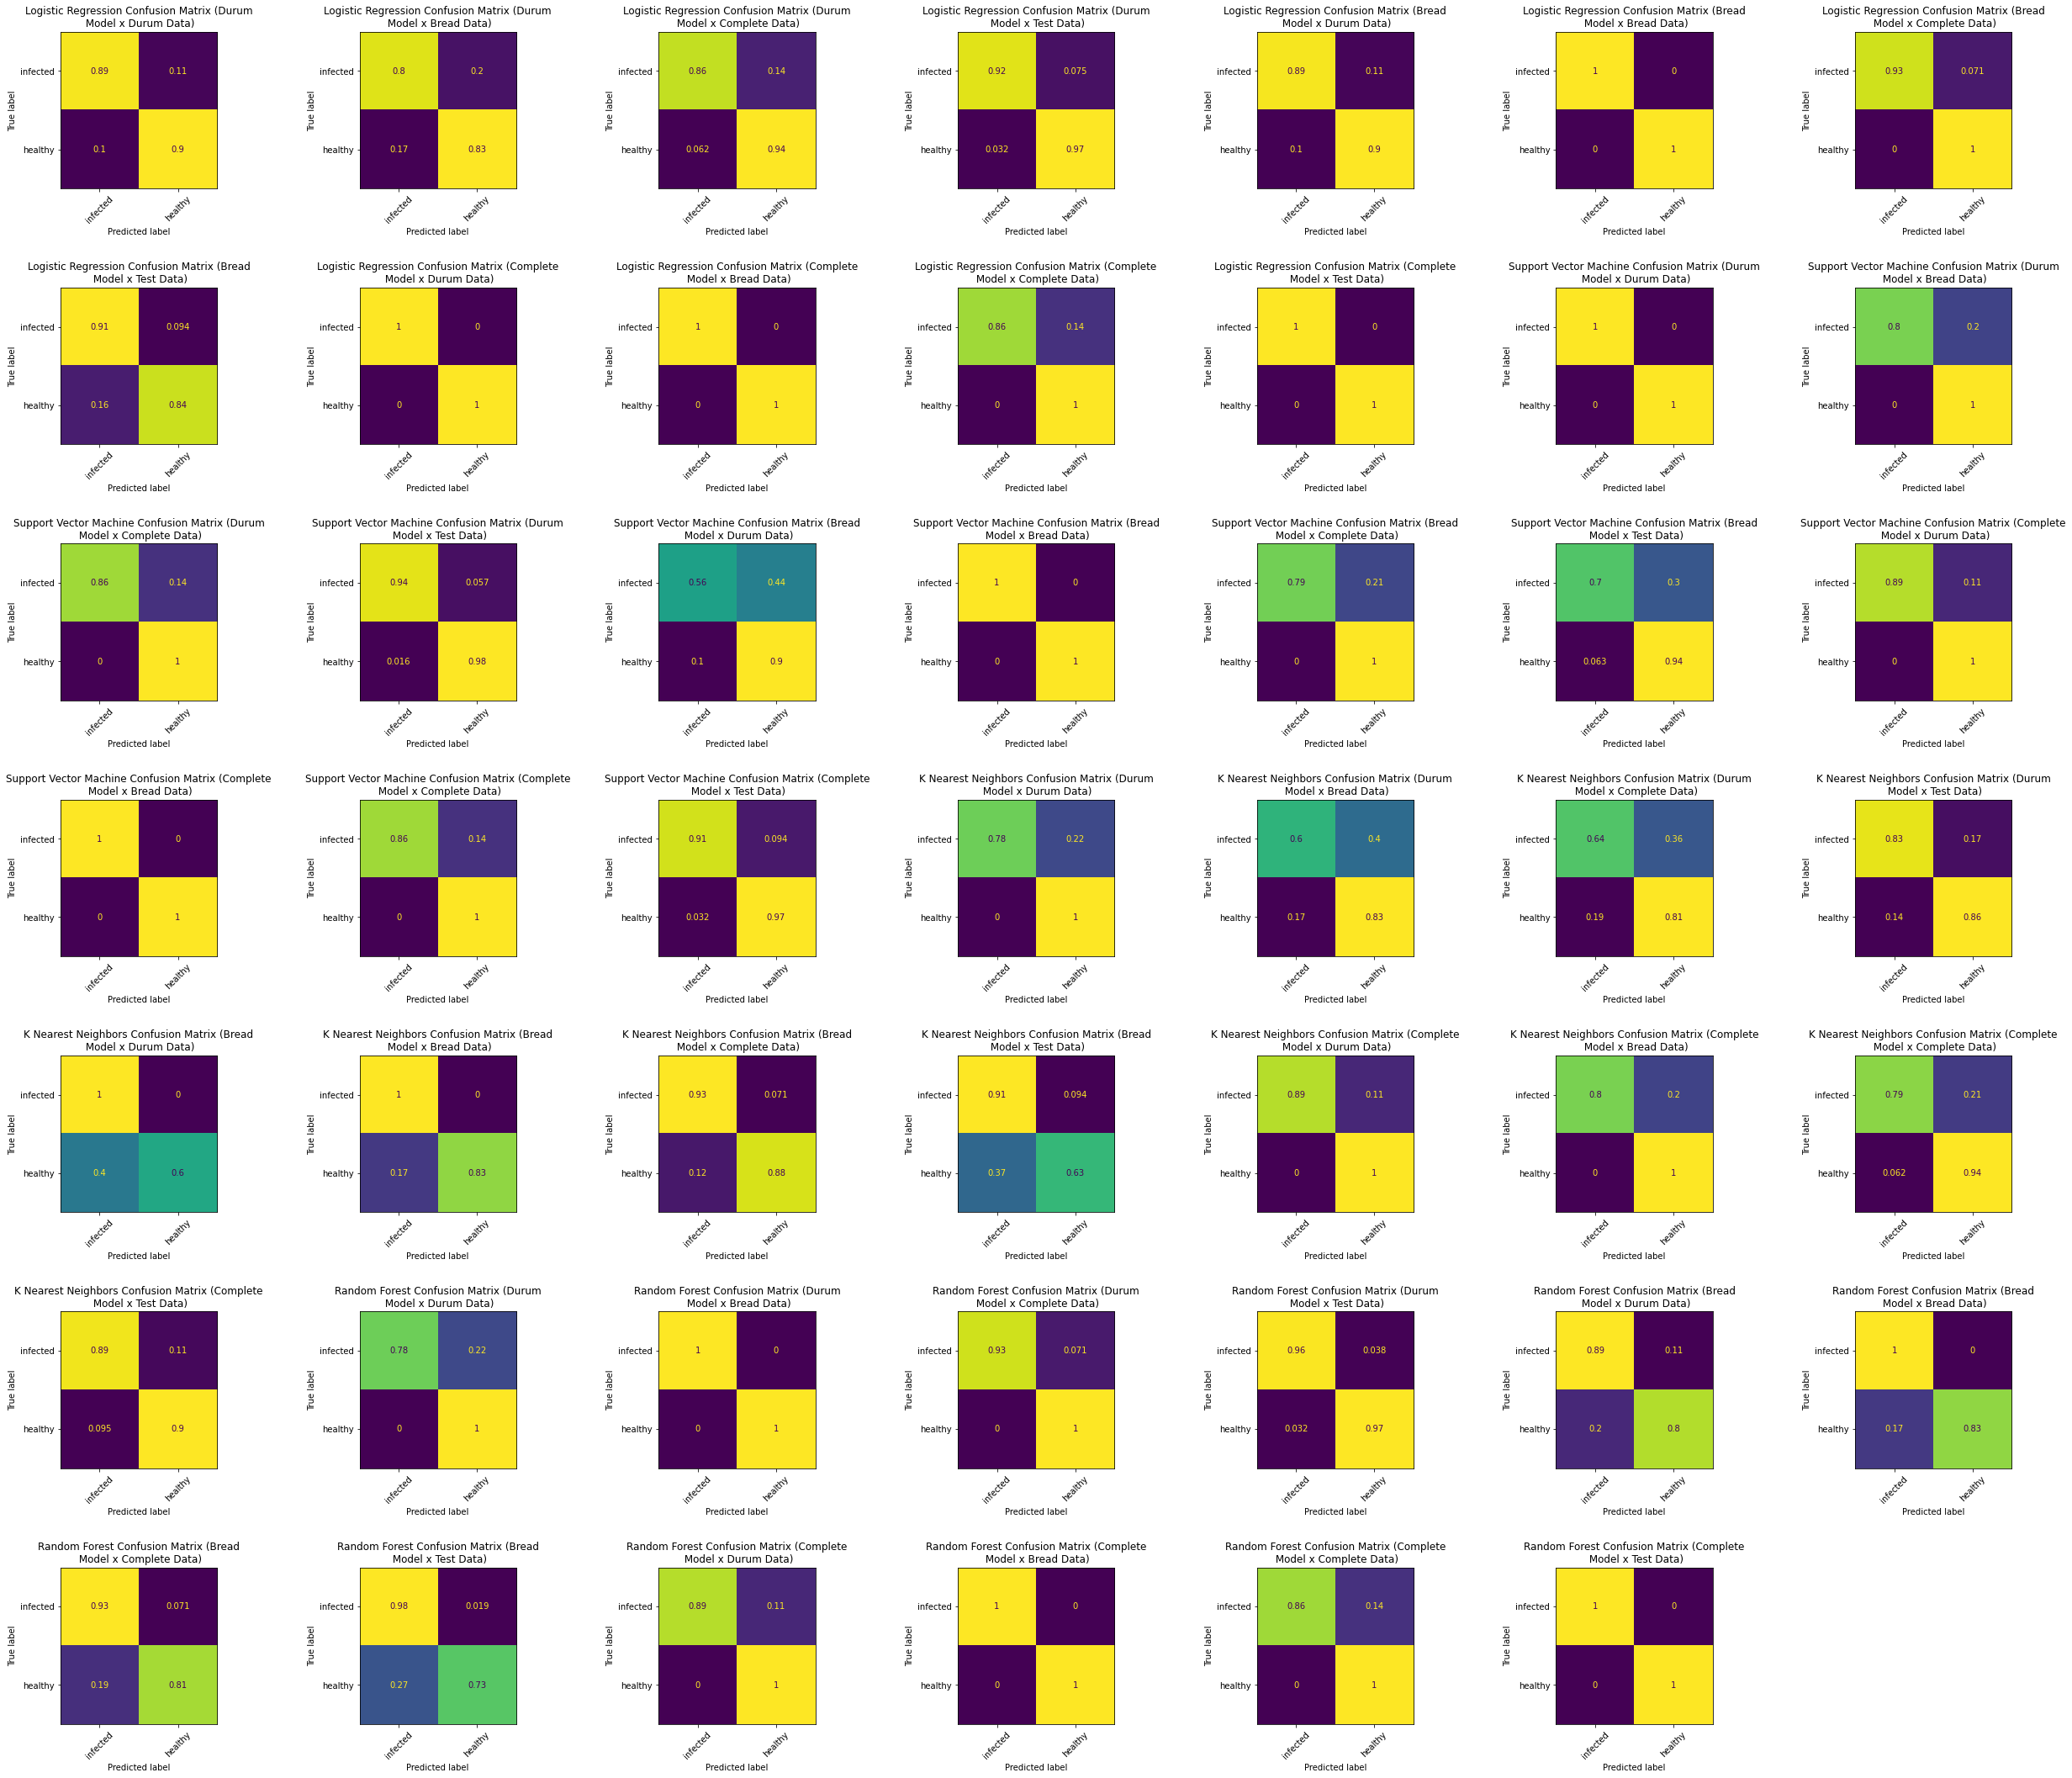

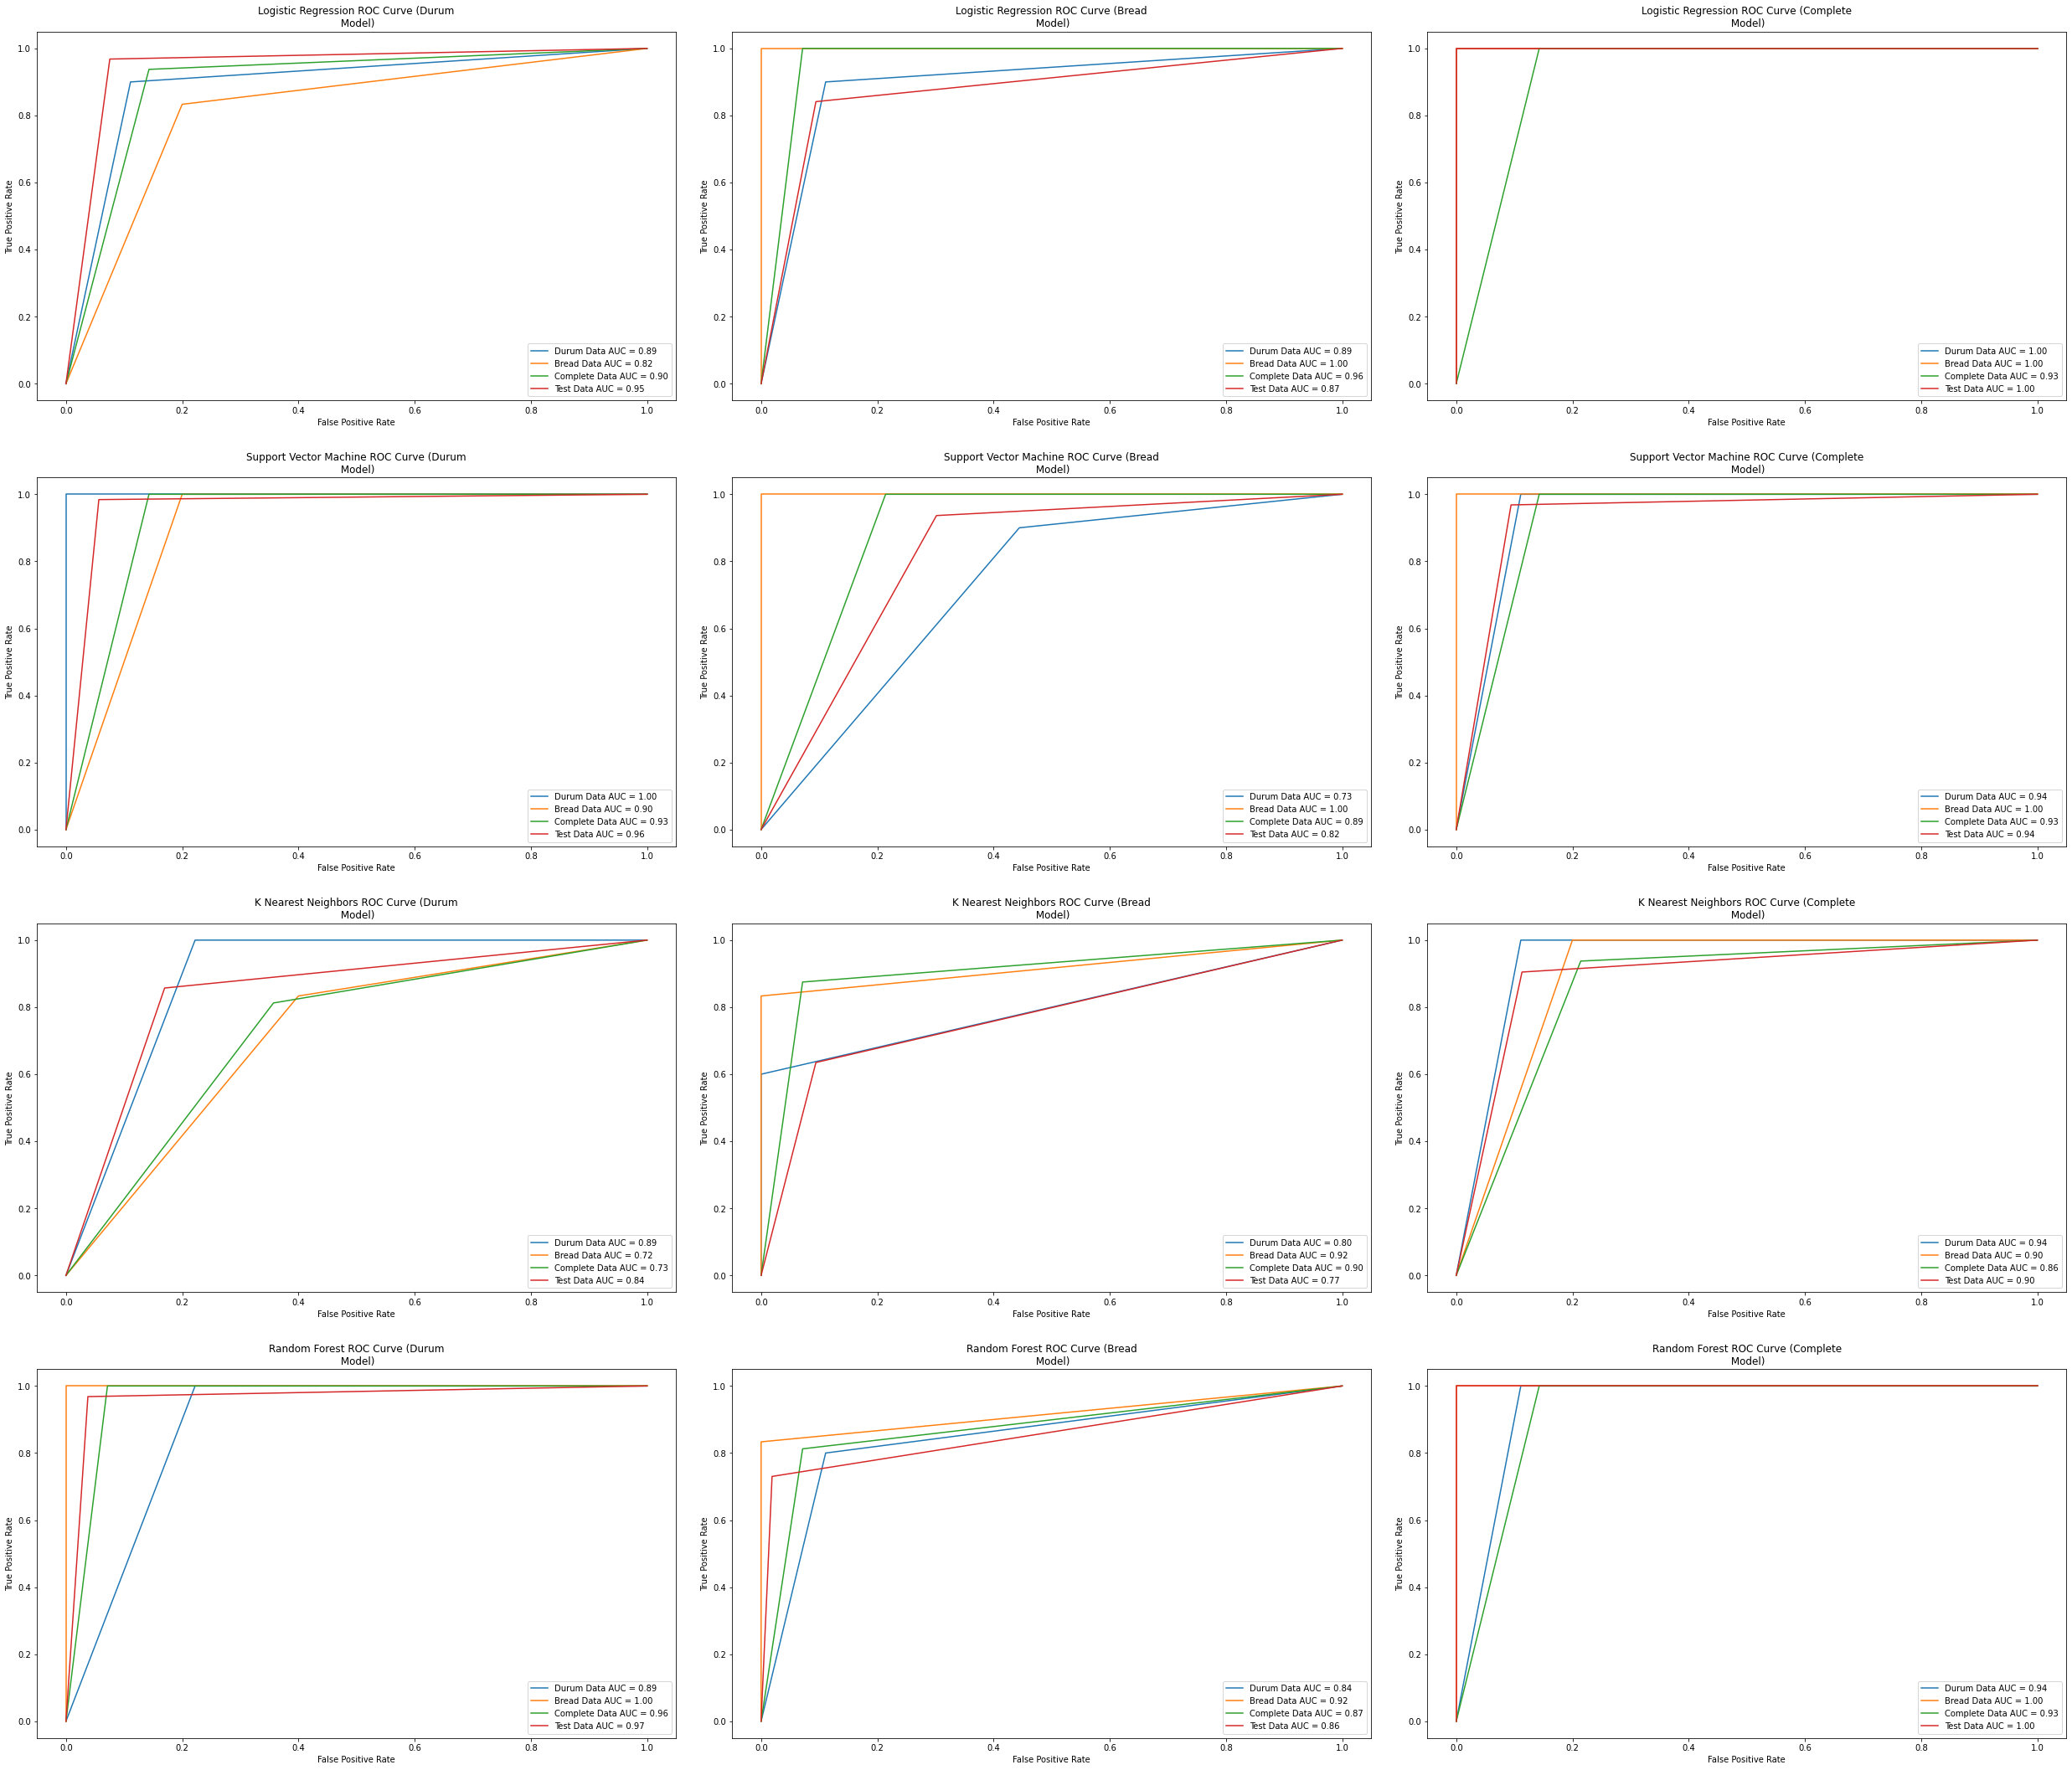

In [21]:
# Generation of confusion matrix for all models

Classification_Label = ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Random Forest']
Classification_Model = [ [LogR_model_Durum, LogR_model_Bread, LogR_model_Complete], [SVM_model_Durum, SVM_model_Bread, SVM_model_Complete], [KNN_model_Durum, KNN_model_Bread, KNN_model_Complete], [RanF_model_Durum, RanF_model_Bread, RanF_model_Complete]]
Train_Labels = ['Durum', 'Bread', 'Complete']
Test_Data_Sets = [(x_test_Durum, y_test_Durum), (x_test_Bread, y_test_Bread), (x_test_Complete, y_test_Complete), (x_test_Test, y_test_Test)]
Data_Set_Label = ['Durum', 'Bread', 'Complete', 'Test']


classification_model = []
train_data_used = []
test_data_used = []
false_positive_rate = [] # fp / (fp + tn)
false_negative_rate = [] # fn / (tp + fn)
true_negative_rate = [] # tn / (tn + fp)
negative_predictive_value = [] # tn / (tn + fn)
false_discovery_rate = [] # fp / (tp + fp)
true_positive_rate = [] # tp / (tp + fn)
precision = [] # tp / (tp + fp)
accuracy = [] # (tp + tn) / (tp + fp + fn + tn) 
f1_score = [] 
f2_score = []

fig_conf, axes_conf = plt.subplots(nrows=7, ncols=7, figsize=(35,30))
fig_roc, axes_roc = plt.subplots(nrows=4, ncols=3, figsize=(35,30))
axes_conf = axes_conf.flatten()
axes_roc = axes_roc.flatten()
i=0

for C_Label, C_Models in zip(Classification_Label, Classification_Model):
    for Model, T_Label in zip(C_Models, Train_Labels):
        for Test_Set, Test_Data_Label in zip(Test_Data_Sets, Data_Set_Label):
            
            y_test_pred = Model.predict(Test_Set[0])
            
            # For confusion matrix
            cf_matrix = confusion_matrix(Test_Set[1], y_test_pred)
            ncf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]            
            disp_conf = ConfusionMatrixDisplay(ncf_matrix ,display_labels=['infected', 'healthy'])
            disp_conf.plot(ax=axes_conf[i], xticks_rotation=45)
            disp_conf.im_.colorbar.remove()
            axes_conf[i].title.set_text(f"{C_Label} Confusion Matrix ({T_Label}\n Model x {Test_Data_Label} Data)")

            # For metrics table
            tn, fp, fn, tp = cf_matrix.ravel()
            classification_model.append(C_Label)
            train_data_used.append(T_Label)
            test_data_used.append(Test_Data_Label)
            false_positive_rate.append(fp / (fp + tn))
            false_negative_rate.append(fn / (tp + fn)) 
            true_negative_rate.append(tn / (tn + fp)) 
            negative_predictive_value.append(tn / (tn + fn))
            false_discovery_rate.append(fp / (tp + fp))
            true_positive_rate.append(tp / (tp + fn))
            precision.append(tp / (tp + fp)) 
            accuracy.append((tp + tn) / (tp + fp + fn + tn))
            f1_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=1))
            f2_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=2))

            # For auc_roc curve
            fpr, tpr, thresholds = roc_curve(Test_Set[1], y_test_pred)
            roc_auc = auc(fpr, tpr)
            disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)  
            disp_roc.plot(ax=axes_roc[i//4], label=f"{Test_Data_Label} Data AUC = {roc_auc:.2f}")
            axes_roc[i//4].title.set_text(f"{C_Label} ROC Curve ({T_Label}\n Model)")
             
            i = i + 1

axes_conf[48].set_axis_off()
fig_conf.tight_layout(pad=3.0)
# fig_conf.savefig('confusion_matrix.png')

fig_roc.tight_layout(pad=3.0)
fig_roc.savefig('ROC_curve.png')

In [15]:
# Generate metrics table
metrics_df = pd.DataFrame(list(zip(classification_model,train_data_used,test_data_used,false_positive_rate,false_negative_rate,true_negative_rate,negative_predictive_value,false_discovery_rate,true_positive_rate,precision,accuracy,f1_score,f2_score)),
               columns =['Classifier', 'Training Data', 'Test Data', 'False Positive Rate', 'False Negative Rate', 'True Negative Rate', 'Negative Predictive Value', 'False Discovery Rate', 'True Positive Rate', 'Precision', 'Accuracy', 'F1 Score', 'F2 Score'])


metrics_df.to_csv('metrics_df.csv',index=False)
